# Block 1

In [7]:
import pybamm
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# Block 2

In [8]:
# Set up the battery model (DFN model)
model = pybamm.lithium_ion.DFN()
param = model.default_parameter_values

# Define attack start and end times
attack_start_time = 100  # Start attack at 100 seconds
attack_end_time = 200    # End attack at 200 seconds

# Perturbation scaling for a feasible attack
perturbation_amplitude = 0.005  # Start with a very low perturbation amplitude
perturbation_increase = 0.02  # Gradually increase perturbation over time

# Define the attack parameters: current, SEI resistance
def adversarial_current(t, perturbation_amplitude, perturbation_increase, for_plot=False):
    base_current = 3  # Constant 3A discharge
    transition_width = 10  # Smooth transition width for attack

    # If for plotting, use numpy.tanh; otherwise use pybamm.tanh for PyBaMM simulations
    tanh_func = np.tanh if for_plot else pybamm.tanh

    # Smooth transition for attack window
    attack_window = 0.5 * (1 + tanh_func((t - attack_start_time) / transition_width)) * \
                    0.5 * (1 + tanh_func((attack_end_time - t) / transition_width))

    # Apply dynamic perturbation that increases over time
    perturbation = attack_window * (perturbation_amplitude + perturbation_increase * (t - attack_start_time))
   
    return base_current + perturbation

# Block 3

In [4]:
# Manipulate SEI resistance as part of the attack (Simulate internal resistance increase)
def adversarial_sei_resistance(t, sei_increase):
    base_sei_resistance = 1e-3  # Base SEI resistance in Ohm.m2
    transition_width = 10  # Smooth transition width for attack

    # Smooth transition for attack window using PyBaMM's tanh
    attack_window = 0.5 * (1 + pybamm.tanh((t - attack_start_time) / transition_width)) * \
                    0.5 * (1 + pybamm.tanh((attack_end_time - t) / transition_width))

    # Slowly increase SEI resistance
    resistance_spike = attack_window * sei_increase + base_sei_resistance  # Increase resistance
    return resistance_spike

In [15]:
# Manipulate SEI resistance as part of the attack (Simulate internal resistance increase)
def adversarial_sei_resistance(t, sei_increase):
    base_sei_resistance = 1e-3  # Base SEI resistance in Ohm.m2
    transition_width = 10  # Smooth transition width for attack

    # Smooth transition for attack window using PyBaMM's tanh
    attack_window = 0.5 * (1 + pybamm.tanh((t - attack_start_time) / transition_width)) * \
                    0.5 * (1 + pybamm.tanh((attack_end_time - t) / transition_width))

    # Slowly increase SEI resistance
    resistance_spike = attack_window * sei_increase + base_sei_resistance  # Increase resistance
    return resistance_spike

# Manipulate temperature as part of the attack (Simulate thermal degradation)
def adversarial_temperature(t, temperature_spike, for_plot=False):
    base_temperature = 298.15  # Base temperature in K (25°C)
    transition_width = 10  # Smooth transition width for attack

    # Use numpy.tanh for plotting and pybamm.tanh for simulations
    tanh_func = np.tanh if for_plot else pybamm.tanh

    # Smooth transition for attack window
    attack_window = 0.5 * (1 + tanh_func((t - attack_start_time) / transition_width)) * \
                    0.5 * (1 + tanh_func((attack_end_time - t) / transition_width))

    # Apply temperature spike during attack window
    temp_perturbation = attack_window * temperature_spike + base_temperature  # Increase temperature
    return temp_perturbation


In [20]:
# Modify the temperature attack for a lasting impact using smooth transitions
def adversarial_temperature(t, temperature_spike, for_plot=False):
    base_temperature = 298.15  # Base temperature in K (25°C)
    transition_width = 10  # Smooth transition width for attack

    # Use numpy.tanh for plotting and pybamm.tanh for simulations
    tanh_func = np.tanh if for_plot else pybamm.tanh

    # Smooth transition for attack window, maintaining elevated temperature after attack
    attack_window = 0.5 * (1 + tanh_func((t - attack_start_time) / transition_width)) * \
                    0.5 * (1 + tanh_func((attack_end_time - t) / transition_width))

    # After attack, maintain a lasting effect using another smooth transition
    after_attack = 0.5 * (1 + tanh_func((t - attack_end_time) / transition_width))

    # Combine both windows to keep the temperature elevated after the attack window ends
    temp_perturbation = attack_window * temperature_spike + after_attack * temperature_spike + base_temperature
    
    return temp_perturbation


# Block 4

In [5]:
# Solve the model without adversarial attack (normal scenario)
t_eval = np.linspace(0, 1000, 500)
sim_normal = pybamm.Simulation(model, parameter_values=param)
solution_normal = sim_normal.solve(t_eval)
voltage_normal = solution_normal["Terminal voltage [V]"].entries
current_normal = np.full_like(t_eval, 3)  # Nominal current is constant at 3A

# Define an objective function to maximize the voltage deviation
def objective(params):
    perturbation_amplitude, perturbation_increase, sei_increase = params
   
    # Update parameters with adversarial attack functions
    param.update({
        "Current function [A]": adversarial_current(pybamm.t, perturbation_amplitude, perturbation_increase),
        "Negative electrode SEI resistance [Ohm.m2]": adversarial_sei_resistance(pybamm.t, sei_increase)
    }, check_already_exists=False)
   
    # Solve the model with adversarial attack
    sim = pybamm.Simulation(model, parameter_values=param)
   
    try:
        solution = sim.solve(t_eval)
    except pybamm.SolverError:
        return np.inf  # Penalize if the solver fails
   
    # Extract relevant data from the solution
    voltage = solution["Terminal voltage [V]"].entries
    voltage_interp = interp1d(solution["Time [s]"].entries, voltage, kind="linear", fill_value="extrapolate")
   
    # Interpolate normal solution to the adversarial time grid
    voltage_normal_interp = interp1d(solution_normal["Time [s]"].entries, voltage_normal, kind="linear", fill_value="extrapolate")
   
    common_time = np.linspace(0, 1000, 500)  # Define a common time grid for comparison
    voltage_adversarial = voltage_interp(common_time)
    voltage_normal_resampled = voltage_normal_interp(common_time)
   
    # Calculate deviation
    deviation = np.max(np.abs(voltage_adversarial - voltage_normal_resampled))
    return -deviation  # Minimize the negative of deviation (i.e., maximize the deviation)

In [16]:
# Define an objective function to maximize the voltage deviation
def objective(params):
    perturbation_amplitude, perturbation_increase, sei_increase, temperature_spike = params  # Add temperature_spike
    
    # Update parameters with adversarial attack functions
    param.update({
        "Current function [A]": adversarial_current(pybamm.t, perturbation_amplitude, perturbation_increase),
        "Negative electrode SEI resistance [Ohm.m2]": adversarial_sei_resistance(pybamm.t, sei_increase),
        "Ambient temperature [K]": adversarial_temperature(pybamm.t, temperature_spike)  # Add temperature perturbation
    }, check_already_exists=False)
   
    # Solve the model with adversarial attack
    sim = pybamm.Simulation(model, parameter_values=param)
    
    try:
        solution = sim.solve(t_eval)
    except pybamm.SolverError:
        return np.inf  # Penalize if the solver fails
    
    # Extract relevant data from the solution
    voltage = solution["Terminal voltage [V]"].entries
    voltage_interp = interp1d(solution["Time [s]"].entries, voltage, kind="linear", fill_value="extrapolate")
    
    # Interpolate normal solution to the adversarial time grid
    voltage_normal_interp = interp1d(solution_normal["Time [s]"].entries, voltage_normal, kind="linear", fill_value="extrapolate")
    
    common_time = np.linspace(0, 1000, 500)  # Define a common time grid for comparison
    voltage_adversarial = voltage_interp(common_time)
    voltage_normal_resampled = voltage_normal_interp(common_time)
    
    # Calculate deviation
    deviation = np.max(np.abs(voltage_adversarial - voltage_normal_resampled))
    return -deviation  # Minimize the negative of deviation (i.e., maximize the deviation)


# Block 5

At t = 235.069, , mxstep steps taken before reaching tout.
At t = 235.069 and h = 3.90893e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 235.069, , mxstep steps taken before reaching tout.
At t = 235.069 and h = 1.45818e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 235.07 and h = 1.82021e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 235.07 and h = 9.44843e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 235.069, , mxstep steps taken before reaching tout.
At t = 235.069 and h = 3.90893e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.898, , mxstep steps taken before reaching tout.
At t = 181.898, , mxstep steps taken before reaching tout.
At t = 181.899, , mxstep steps taken before reaching tout.
At t = 181.898 and h = 1.15331e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.898, , mxstep steps taken before reac

Optimal Parameters: [0.1   0.05  0.001]


At t = 181.898, , mxstep steps taken before reaching tout.
At t = 181.898, , mxstep steps taken before reaching tout.


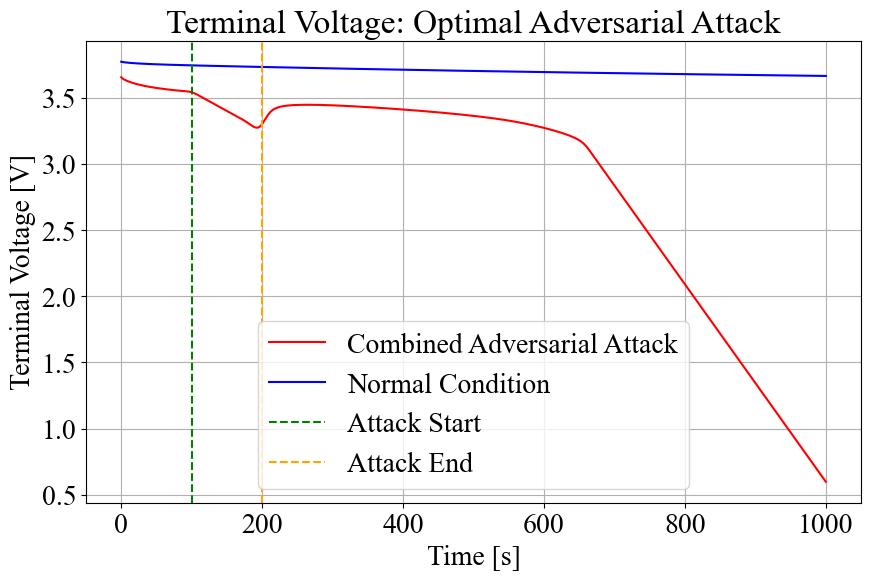

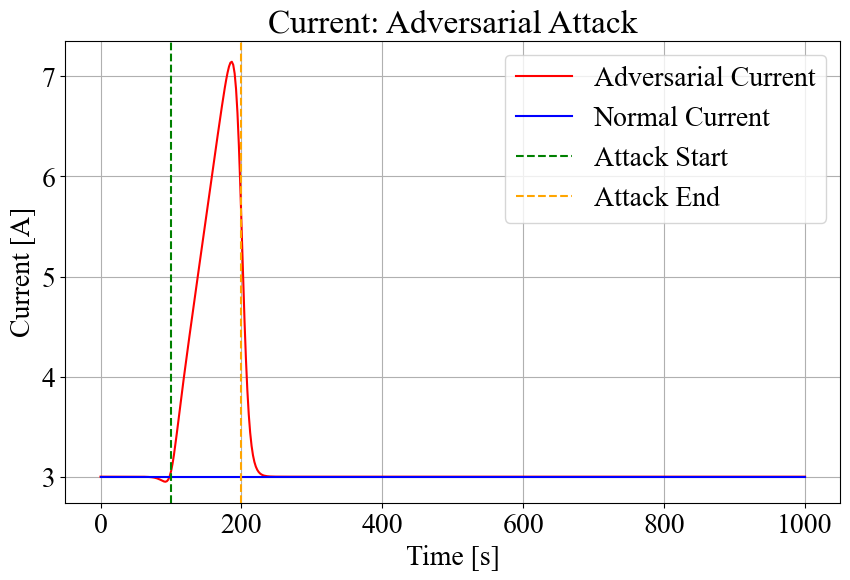

In [6]:
# Set initial guesses for the parameters and run the optimization
initial_guess = [0.005, 0.02, 1e-3]  # Perturbation amplitude, rate, SEI resistance
bounds = [(0, 0.1), (0, 0.05), (1e-3, 2e-3)]  # Tight bounds for more controlled attacks
result = minimize(objective, initial_guess, bounds=bounds, method="L-BFGS-B")

# Extract optimal parameters and plot the results
optimal_params = result.x
print(f"Optimal Parameters: {optimal_params}")

# Now plot the results with the optimal parameters
param.update({
    "Current function [A]": adversarial_current(pybamm.t, optimal_params[0], optimal_params[1]),
    "Negative electrode SEI resistance [Ohm.m2]": adversarial_sei_resistance(pybamm.t, optimal_params[2])
})

# Solve with optimal parameters
sim = pybamm.Simulation(model, parameter_values=param)
solution_opt = sim.solve(t_eval)

# Extract adversarial voltage
voltage_opt = solution_opt["Terminal voltage [V]"].entries
time_voltage = solution_opt["Time [s]"].entries

# Interpolate the adversarial solution to match the time grid of t_eval
voltage_opt_interp = interp1d(time_voltage, voltage_opt, kind="linear", fill_value="extrapolate")(t_eval)

# Configure plot for Times New Roman and font size 20
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman']
plt.rcParams['font.size'] = 20

# Plot the terminal voltage
plt.figure(figsize=(10, 6))
plt.plot(t_eval, voltage_opt_interp, label="Combined Adversarial Attack", color='red')
plt.plot(t_eval, voltage_normal, label="Normal Condition", color='blue')
plt.axvline(x=attack_start_time, color='green', linestyle='--', label="Attack Start")
plt.axvline(x=attack_end_time, color='orange', linestyle='--', label="Attack End")
plt.xlabel("Time [s]")
plt.ylabel("Terminal Voltage [V]")
plt.title("Terminal Voltage: Optimal Adversarial Attack")
plt.legend()
plt.grid(True)
plt.savefig("terminal_voltage_attack.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Plot current
plt.figure(figsize=(10, 6))
plt.plot(t_eval, adversarial_current(t_eval, optimal_params[0], optimal_params[1], for_plot=True), label="Adversarial Current", color='red')
plt.plot(t_eval, current_normal, label="Normal Current", color='blue')
plt.axvline(x=attack_start_time, color='green', linestyle='--', label="Attack Start")
plt.axvline(x=attack_end_time, color='orange', linestyle='--', label="Attack End")
plt.xlabel("Time [s]")
plt.ylabel("Current [A]")
plt.title("Current: Adversarial Attack")
plt.legend()
plt.grid(True)
plt.savefig("current_attack.pdf", format="pdf", bbox_inches="tight")
plt.show()

At t = 235.069, , mxstep steps taken before reaching tout.
At t = 235.069, , mxstep steps taken before reaching tout.
At t = 235.069 and h = 1.72836e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 235.069, , mxstep steps taken before reaching tout.
At t = 235.069 and h = 8.19087e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 235.069, , mxstep steps taken before reaching tout.
At t = 235.069, , mxstep steps taken before reaching tout.
At t = 235.069, , mxstep steps taken before reaching tout.
At t = 235.069, , mxstep steps taken before reaching tout.
At t = 235.069 and h = 1.88688e-14, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 181.904, , mxstep steps taken before reaching tout.
At t = 181.904, , mxstep steps taken before reaching tout.
At t = 181.904, , mxstep steps taken before reaching tout.
At t = 181.904, , mxstep steps taken before reaching tout.
At t = 181.904, , mxstep steps taken before reachin

Optimal Parameters: [1.00000000e-01 5.00000000e-02 1.00000000e-03 9.72559508e+00]


At t = 181.902, , mxstep steps taken before reaching tout.
At t = 181.902, , mxstep steps taken before reaching tout.


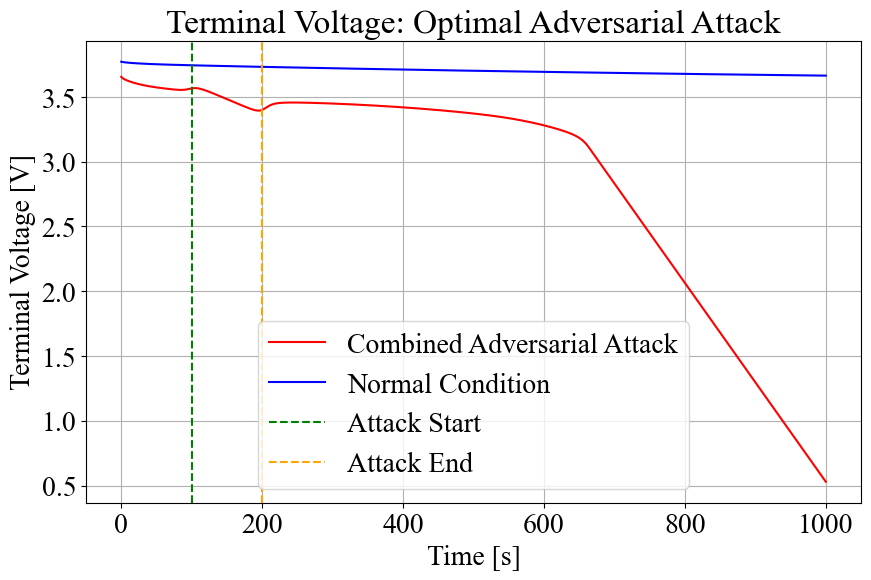

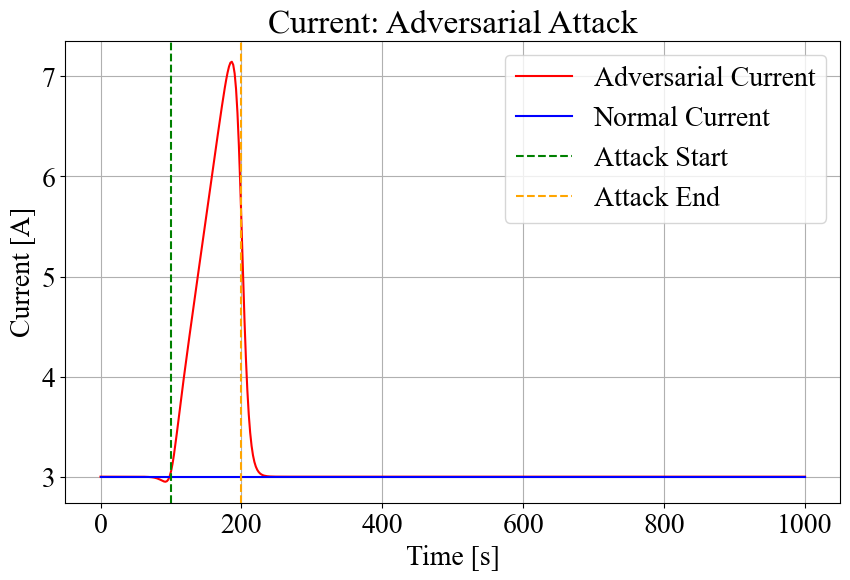

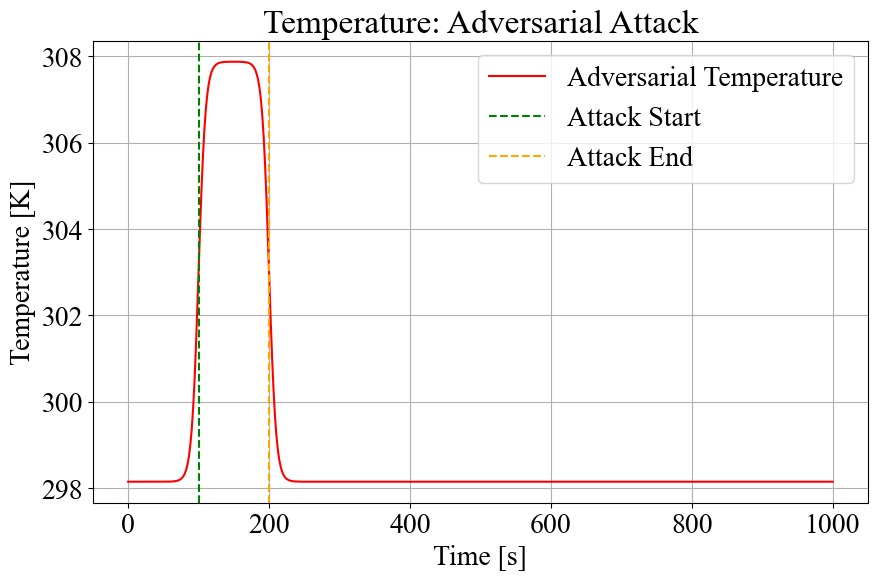

In [14]:
# Set initial guesses for the parameters and run the optimization
initial_guess = [0.005, 0.02, 1e-3, 10]  # Add temperature spike to the list
bounds = [(0, 0.1), (0, 0.05), (1e-3, 2e-3), (0, 15)]  # Add bounds for temperature spike (from 0 to 15 K)

result = minimize(objective, initial_guess, bounds=bounds, method="L-BFGS-B")

# Extract optimal parameters and plot the results
optimal_params = result.x
print(f"Optimal Parameters: {optimal_params}")

# Now plot the results with the optimal parameters
param.update({
    "Current function [A]": adversarial_current(pybamm.t, optimal_params[0], optimal_params[1]),
    "Negative electrode SEI resistance [Ohm.m2]": adversarial_sei_resistance(pybamm.t, optimal_params[2]),
    "Ambient temperature [K]": adversarial_temperature(pybamm.t, optimal_params[3])  # Add temperature perturbation
})

# Solve with optimal parameters
sim = pybamm.Simulation(model, parameter_values=param)
solution_opt = sim.solve(t_eval)

# Extract adversarial voltage
voltage_opt = solution_opt["Terminal voltage [V]"].entries
time_voltage = solution_opt["Time [s]"].entries

# Interpolate the adversarial solution to match the time grid of t_eval
voltage_opt_interp = interp1d(time_voltage, voltage_opt, kind="linear", fill_value="extrapolate")(t_eval)

# Plot the terminal voltage
plt.figure(figsize=(10, 6))
plt.plot(t_eval, voltage_opt_interp, label="Combined Adversarial Attack", color='red')
plt.plot(t_eval, voltage_normal, label="Normal Condition", color='blue')
plt.axvline(x=attack_start_time, color='green', linestyle='--', label="Attack Start")
plt.axvline(x=attack_end_time, color='orange', linestyle='--', label="Attack End")
plt.xlabel("Time [s]")
plt.ylabel("Terminal Voltage [V]")
plt.title("Terminal Voltage: Optimal Adversarial Attack")
plt.legend()
plt.grid(True)
plt.savefig("terminal_voltage_attack.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Plot current
plt.figure(figsize=(10, 6))
plt.plot(t_eval, adversarial_current(t_eval, optimal_params[0], optimal_params[1], for_plot=True), label="Adversarial Current", color='red')
plt.plot(t_eval, current_normal, label="Normal Current", color='blue')
plt.axvline(x=attack_start_time, color='green', linestyle='--', label="Attack Start")
plt.axvline(x=attack_end_time, color='orange', linestyle='--', label="Attack End")
plt.xlabel("Time [s]")
plt.ylabel("Current [A]")
plt.title("Current: Adversarial Attack")
plt.legend()
plt.grid(True)
plt.savefig("current_attack.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Plot temperature
plt.figure(figsize=(10, 6))
plt.plot(t_eval, adversarial_temperature(t_eval, optimal_params[3], for_plot=True), label="Adversarial Temperature", color='red')
plt.axvline(x=attack_start_time, color='green', linestyle='--', label="Attack Start")
plt.axvline(x=attack_end_time, color='orange', linestyle='--', label="Attack End")
plt.xlabel("Time [s]")
plt.ylabel("Temperature [K]")
plt.title("Temperature: Adversarial Attack")
plt.legend()
plt.grid(True)
plt.savefig("temperature_attack.pdf", format="pdf", bbox_inches="tight")
plt.show()

At t = 195.906 and h = 2.31497e-16, the corrector convergence failed repeatedly or with |h| = hmin.
At t = 195.906 and h = 4.34063e-16, the corrector convergence failed repeatedly or with |h| = hmin.


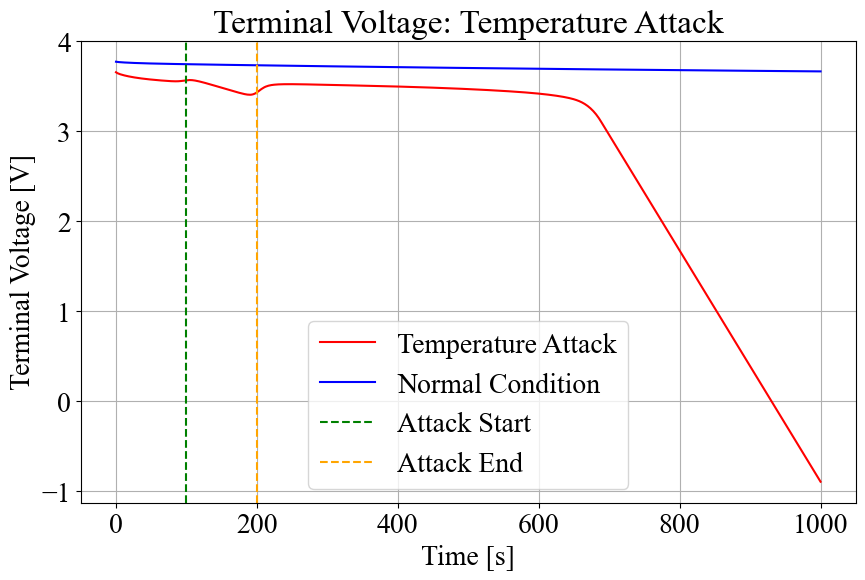

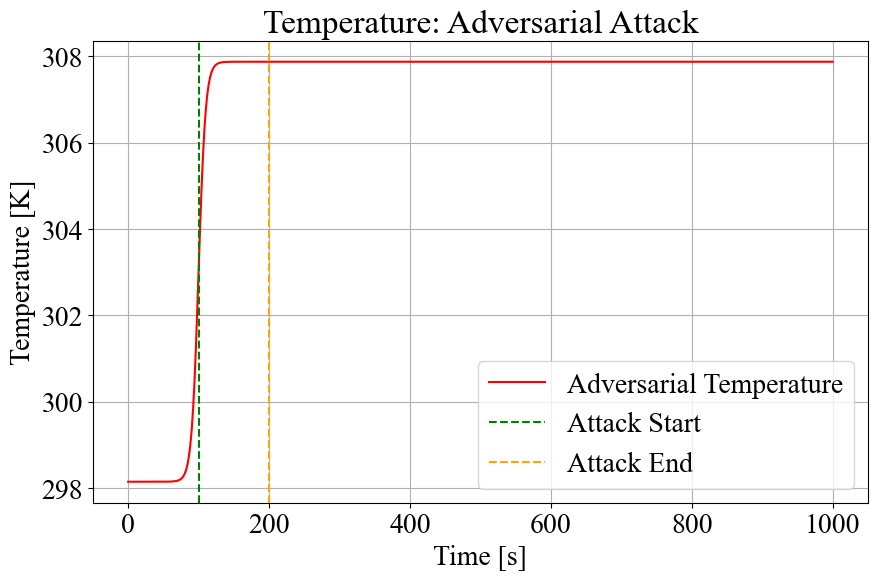

In [21]:
# Run the temperature attack with optimal parameters
param.update({
    "Ambient temperature [K]": adversarial_temperature(pybamm.t, optimal_params[3])  # Add temperature perturbation only
})

# Solve the model with the temperature attack
sim_temp = pybamm.Simulation(model, parameter_values=param)
solution_temp = sim_temp.solve(t_eval)

# Extract adversarial voltage after temperature attack
voltage_temp = solution_temp["Terminal voltage [V]"].entries
time_voltage_temp = solution_temp["Time [s]"].entries

# Interpolate the adversarial solution to match the time grid of t_eval
voltage_temp_interp = interp1d(time_voltage_temp, voltage_temp, kind="linear", fill_value="extrapolate")(t_eval)

# Plot the terminal voltage with temperature attack
plt.figure(figsize=(10, 6))
plt.plot(t_eval, voltage_temp_interp, label="Temperature Attack", color='red')
plt.plot(t_eval, voltage_normal, label="Normal Condition", color='blue')
plt.axvline(x=attack_start_time, color='green', linestyle='--', label="Attack Start")
plt.axvline(x=attack_end_time, color='orange', linestyle='--', label="Attack End")
plt.xlabel("Time [s]")
plt.ylabel("Terminal Voltage [V]")
plt.title("Terminal Voltage: Temperature Attack")
plt.legend()
plt.grid(True)
plt.savefig("terminal_voltage_temp_attack.pdf", format="pdf", bbox_inches="tight")
plt.show()

# Plot temperature profile
plt.figure(figsize=(10, 6))
plt.plot(t_eval, adversarial_temperature(t_eval, optimal_params[3], for_plot=True), label="Adversarial Temperature", color='red')
plt.axvline(x=attack_start_time, color='green', linestyle='--', label="Attack Start")
plt.axvline(x=attack_end_time, color='orange', linestyle='--', label="Attack End")
plt.xlabel("Time [s]")
plt.ylabel("Temperature [K]")
plt.title("Temperature: Adversarial Attack")
plt.legend()
plt.grid(True)
plt.savefig("temperature_profile_temp_attack.pdf", format="pdf", bbox_inches="tight")
plt.show()
